In [1]:
#!pip install nibabel tqdm scikit-image

In [2]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable


from tensorflow.python.client import device_lib

In [3]:
#데이터 셋 가져오기
def get_mask_data():

    x_train_path = "dataset/Image_Segmentation/x_train2.npy"
    x_val_path = "dataset/Image_Segmentation/x_val2.npy" 
    y_train_path = "dataset/Image_Segmentation/y_train2.npy"
    y_val_path = "dataset/Image_Segmentation/y_val2.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)
    
        
    return x_train, y_train, x_val, y_val


In [4]:
# CNN 인 VGG16 U-net
def VGG16_Unet(x_train, y_train, x_val, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

    #down sampling 
    filters = 16       #feature map 수
    kernel_size = 3    # kernel size
    copy_layers = []   # Encoder에 있는 Activation map을 저장하는 리스트
    net = inputs
  
    #Encoder1
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #첫번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder2 
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #두번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder3
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #세번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    filters = filters*2
    
    #Encoder4
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #네번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #Encoder5
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    copy_layers.append(net) #다섯번째 Activation map 저장
    net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
    
    #128
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    
    #Decoder : upsampling
    j = len(copy_layers) - 1
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #다섯번째 Activation map 
    
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    j = j -1 

    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #네번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #세번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)

    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #두번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    filters = filters/2
    j = j -1 
    
    net = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, copy_layers[j]]) #첫번째 Activation map
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = Conv2D(filters, kernel_size, activation='relu', padding='same') (net)
    net = BatchNormalization() (net)
    
    outputs = Conv2D(2, 1, activation='sigmoid') (net)




    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', 
                  metrics=['acc',tf.keras.metrics.MeanIoU(num_classes=2)])

    model.summary()
    
    
    

    return model

In [5]:
def Unet(x_train, y_train, x_val, y_val) :
    
    inputs = Input(shape=(256, 256, 1))
    
    f = 16
    layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        f = f*2
        #512
    ff2 = 256
  
    #bottleneck 
    j = len(layers) - 1
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        print(net.shape)
        net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, layers[j]])
        j = j -1 
    
  
    #classification 
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(2, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse', tf.keras.metrics.MeanIoU(num_classes=2)])
    model.summary()
    
    return model

In [6]:
def training(model,x_train, y_train, x_val, y_val) :
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
    fig, ax = plt.subplots(3, 2, figsize=(10, 7))
    plt.subplots_adjust(left=0.125,bottom=0.1, right=0.9, top=1.5, wspace=0.2, hspace=0.35)

    
    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')
    
    ax[2,0].set_title('MeanIoU')
    ax[2,0].plot(history.history['mean_io_u'], 'r')
    ax[2,1].set_title('val_MeanIoU')
    ax[2,1].plot(history.history['val_mean_io_u'], 'r')
    

#     preds = model.predict(x_val)
#     fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
#     temp = np.empty((256, 256, 1), dtype=np.float32)

#     for i in range(40):
#         ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
#         ax[i, 0].title.set_text(str(i))
    
#         y_val_0 = y_val[...,0]
#         ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
#         predict_0 = preds[...,0]
#         ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
#         temp = x_val[i]
#         pred_sum = predict_0[i][predict_0[i] > 0]
#         pred_mean = np.mean(predict_0)
#         if(np.min(temp) >= 0) :
#             temp[predict_0[i] < 0.5] = 0
#         else :
#             temp[predict_0[i] < 0.5] = -2048
#         ax[i, 3].imshow(temp.squeeze(), cmap='gray')


In [7]:
x_train, y_train, x_val, y_val = get_mask_data()
print(y_train.max(), y_train.min())
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
# model = VGG16_Unet(x_train, y_train2, x_val, y_val2)
# history = training(model,x_train, y_train2, x_val, y_val2)

(2675, 256, 256, 1) (2675, 256, 256, 2)
(298, 256, 256, 1) (298, 256, 256, 2)
1 0
1.0 0.0
1.0 0.0


(None, 8, 8, 512)
(None, 16, 16, 128)
(None, 16, 16, 256)
(None, 32, 32, 64)
(None, 32, 32, 128)
(None, 64, 64, 32)
(None, 64, 64, 64)
(None, 128, 128, 16)
(None, 128, 128, 32)
(None, 256, 256, 8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
_______________________________________________________________________________________________

Epoch 1/30
168/168 [==============================] - 97s 507ms/step - loss: 0.3552 - acc: 0.8683 - mse: 0.1078 - mean_io_u: 0.2560 - val_loss: 0.1857 - val_acc: 0.9438 - val_mse: 0.0523 - val_mean_io_u: 0.2627
Epoch 2/30
168/168 [==============================] - 77s 458ms/step - loss: 0.1297 - acc: 0.9589 - mse: 0.0336 - mean_io_u: 0.2788 - val_loss: 0.1667 - val_acc: 0.9467 - val_mse: 0.0438 - val_mean_io_u: 0.2855
Epoch 3/30
168/168 [==============================] - 77s 459ms/step - loss: 0.0856 - acc: 0.9700 - mse: 0.0232 - mean_io_u: 0.3884 - val_loss: 0.0711 - val_acc: 0.9754 - val_mse: 0.0194 - val_mean_io_u: 0.4268
Epoch 4/30
168/168 [==============================] - 77s 459ms/step - loss: 0.1923 - acc: 0.9219 - mse: 0.0559 - mean_io_u: 0.3667 - val_loss: 0.2360 - val_acc: 0.8674 - val_mse: 0.0723 - val_mean_io_u: 0.2737
Epoch 5/30
168/168 [==============================] - 77s 458ms/step - loss: 0.1180 - acc: 0.9522 - mse: 0.0338 - mean_io_u: 0.3126 - val_loss: 0.0793 - val

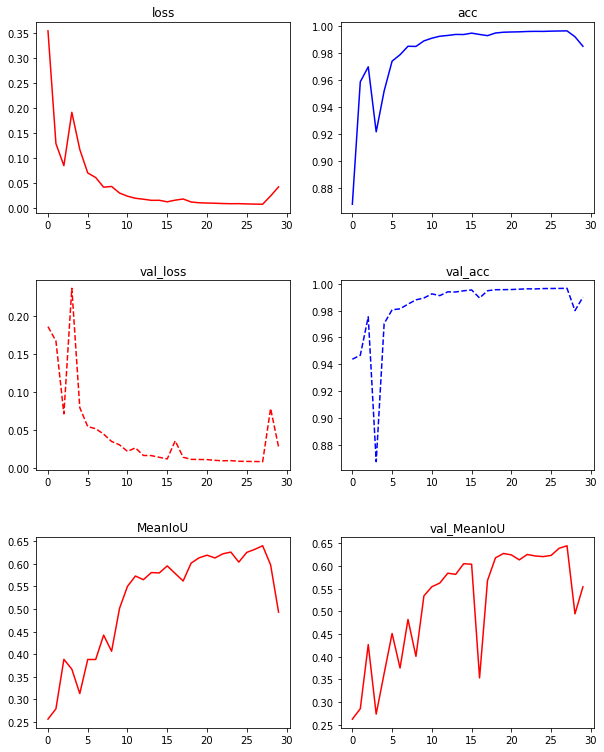

In [8]:
model = Unet(x_train, y_train, x_val, y_val)
history = training(model,x_train, y_train, x_val, y_val)

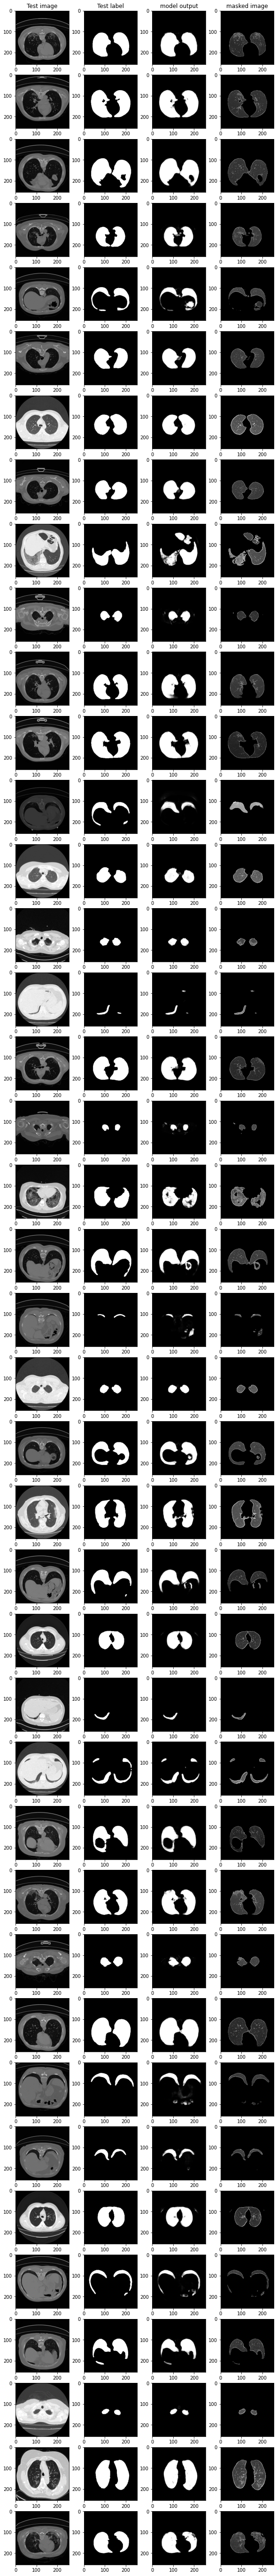

In [9]:
preds = model.predict(x_val)
fig, ax = plt.subplots(40, 4, figsize=(10, 100))
    
temp = np.empty((256, 256, 1), dtype=np.float32)

ax[0, 0].title.set_text("Test image")
ax[0, 1].title.set_text("Test label")
ax[0, 2].title.set_text("model output")
ax[0, 3].title.set_text("masked image")
for i in range(40):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    
    y_val_0 = y_val[...,0]
    ax[i, 1].imshow(y_val_0[i].squeeze(), cmap='gray')
    
    predict_0 = preds[...,0]
    ax[i, 2].imshow(predict_0[i].squeeze(), cmap='gray')
    
    temp = x_val[i]
    pred_sum = predict_0[i][predict_0[i] > 0]
    pred_mean = np.mean(predict_0)
    temp[predict_0[i] < 0.5] = 0
    ax[i, 3].imshow(temp.squeeze(), cmap='gray')
    

In [10]:
y_val_com_0 = y_val[...,0] #image label 
predict_com_0 = preds[...,0] #prediction (model output)

IOU_SUM = 0.0
IOU_AVE = 0.0
Number_image =0

for n,_ in enumerate(y_val_com_0) :
    
    TP = 0
    NP = 0
    index = n
    
    y_label_image = y_val_com_0[index].copy()
    predict_image = predict_com_0[index].copy()

    #model output 0번째 사진의 각 픽셀에 0.5보다 작으면 0 크면 1
    predict_image[predict_image < 0.5] = 0 
    predict_image[predict_image > 0.5] = 1

    #비교 해서 같으면 TP+1 아니면 NP+1
    for i in range(256) :
        for j in range(256) :
            if(y_label_image[i][j] == predict_image[i][j]) :
                TP = TP + 1
            else :
                NP = NP + 1

    print('Number : ', n, 'TP :', TP,'NP : ', NP)
    print('IOU :', TP/ (TP + NP) , '\n')
    IOU_SUM = TP/ (TP + NP) + IOU_SUM
    Number_image = n
    
IOU_AVE = IOU_SUM / (Number_image +  1)
print("IOU_AVE : ", IOU_AVE)


Number :  0 TP : 65158 NP :  378
IOU : 0.994232177734375 

Number :  1 TP : 65063 NP :  473
IOU : 0.9927825927734375 

Number :  2 TP : 64650 NP :  886
IOU : 0.986480712890625 

Number :  3 TP : 65076 NP :  460
IOU : 0.99298095703125 

Number :  4 TP : 63737 NP :  1799
IOU : 0.9725494384765625 

Number :  5 TP : 65163 NP :  373
IOU : 0.9943084716796875 

Number :  6 TP : 65322 NP :  214
IOU : 0.996734619140625 

Number :  7 TP : 65350 NP :  186
IOU : 0.997161865234375 

Number :  8 TP : 62096 NP :  3440
IOU : 0.947509765625 

Number :  9 TP : 65384 NP :  152
IOU : 0.9976806640625 

Number :  10 TP : 64174 NP :  1362
IOU : 0.979217529296875 

Number :  11 TP : 65052 NP :  484
IOU : 0.99261474609375 

Number :  12 TP : 64125 NP :  1411
IOU : 0.9784698486328125 

Number :  13 TP : 65152 NP :  384
IOU : 0.994140625 

Number :  14 TP : 65288 NP :  248
IOU : 0.9962158203125 

Number :  15 TP : 65319 NP :  217
IOU : 0.9966888427734375 

Number :  16 TP : 65154 NP :  382
IOU : 0.99417114257812

Number :  136 TP : 64653 NP :  883
IOU : 0.9865264892578125 

Number :  137 TP : 65356 NP :  180
IOU : 0.99725341796875 

Number :  138 TP : 65245 NP :  291
IOU : 0.9955596923828125 

Number :  139 TP : 65393 NP :  143
IOU : 0.9978179931640625 

Number :  140 TP : 64857 NP :  679
IOU : 0.9896392822265625 

Number :  141 TP : 64741 NP :  795
IOU : 0.9878692626953125 

Number :  142 TP : 65349 NP :  187
IOU : 0.9971466064453125 

Number :  143 TP : 65110 NP :  426
IOU : 0.993499755859375 

Number :  144 TP : 64953 NP :  583
IOU : 0.9911041259765625 

Number :  145 TP : 65249 NP :  287
IOU : 0.9956207275390625 

Number :  146 TP : 65014 NP :  522
IOU : 0.992034912109375 

Number :  147 TP : 64796 NP :  740
IOU : 0.98870849609375 

Number :  148 TP : 65273 NP :  263
IOU : 0.9959869384765625 

Number :  149 TP : 65388 NP :  148
IOU : 0.99774169921875 

Number :  150 TP : 65007 NP :  529
IOU : 0.9919281005859375 

Number :  151 TP : 65334 NP :  202
IOU : 0.996917724609375 

Number :  152 TP 

Number :  270 TP : 64897 NP :  639
IOU : 0.9902496337890625 

Number :  271 TP : 64812 NP :  724
IOU : 0.98895263671875 

Number :  272 TP : 65354 NP :  182
IOU : 0.997222900390625 

Number :  273 TP : 65086 NP :  450
IOU : 0.993133544921875 

Number :  274 TP : 65428 NP :  108
IOU : 0.99835205078125 

Number :  275 TP : 65219 NP :  317
IOU : 0.9951629638671875 

Number :  276 TP : 65210 NP :  326
IOU : 0.995025634765625 

Number :  277 TP : 65354 NP :  182
IOU : 0.997222900390625 

Number :  278 TP : 64510 NP :  1026
IOU : 0.984344482421875 

Number :  279 TP : 65010 NP :  526
IOU : 0.991973876953125 

Number :  280 TP : 65027 NP :  509
IOU : 0.9922332763671875 

Number :  281 TP : 64476 NP :  1060
IOU : 0.98382568359375 

Number :  282 TP : 64713 NP :  823
IOU : 0.9874420166015625 

Number :  283 TP : 65038 NP :  498
IOU : 0.992401123046875 

Number :  284 TP : 64727 NP :  809
IOU : 0.9876556396484375 

Number :  285 TP : 65130 NP :  406
IOU : 0.993804931640625 

Number :  286 TP : 6